In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.2.0+cpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\torch_scatter
      copying torch_scatter\placeholder.py -> build\lib.win-amd64-cpython-311\torch_scatter
      copying torch_scatter\scatter.py -> build\lib.win-amd64-cpython-311\torch_scatter
      copying torch_scatter\segment_coo.py -> build\lib.win-amd64-cpython-311\torch_scatter
      copying torch_scatter\segment_csr.py -> build\lib.win-amd64-cpython-311\torch_scatter
      copying torch_scatter\testing.py -> build\lib.win-amd64-cpython-311\torch_scatter
      copying torch_scatter\utils.py -> build\lib.win-amd64-cpython-311\torch_scatter
      copying torch_scatter\__init__.py -> build\lib.win-amd64-cpython-311\torch_scatter
      creating build\lib.win-amd

# Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.


print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [14]:
import pandas as pd

C:\Users\fsimiao\AppData\Local\Temp\ipykernel_21944\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [61]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [62]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [63]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


### Algoritmo de classificar documentos

As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [68]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        
        return x

model = GCN(hidden_channels=16)
print(model)



GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

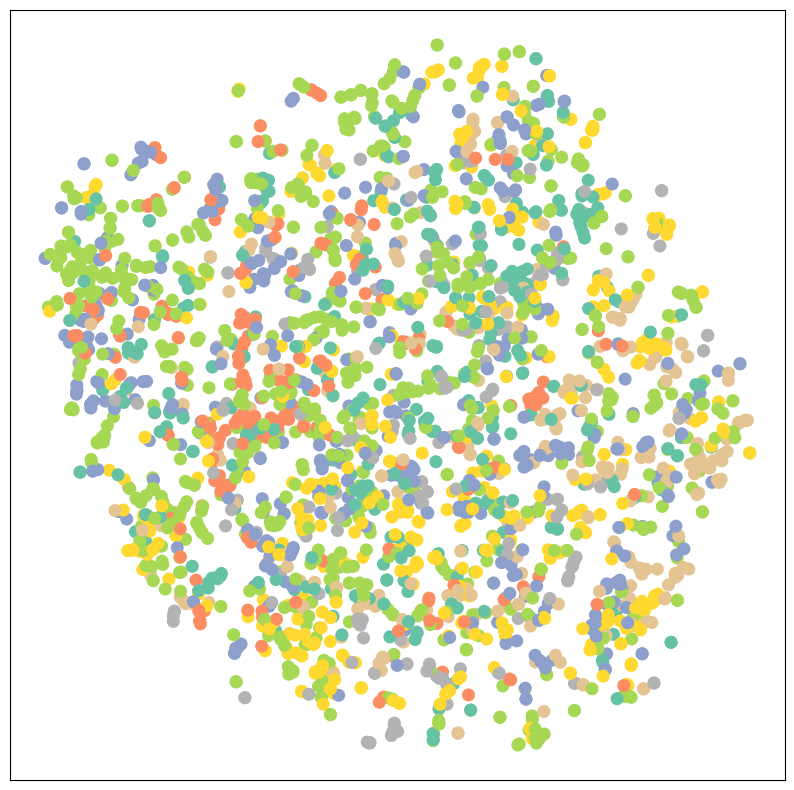

In [69]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [70]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 600):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


After training the model, we can check its test accuracy:

In [71]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8120


**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.5% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

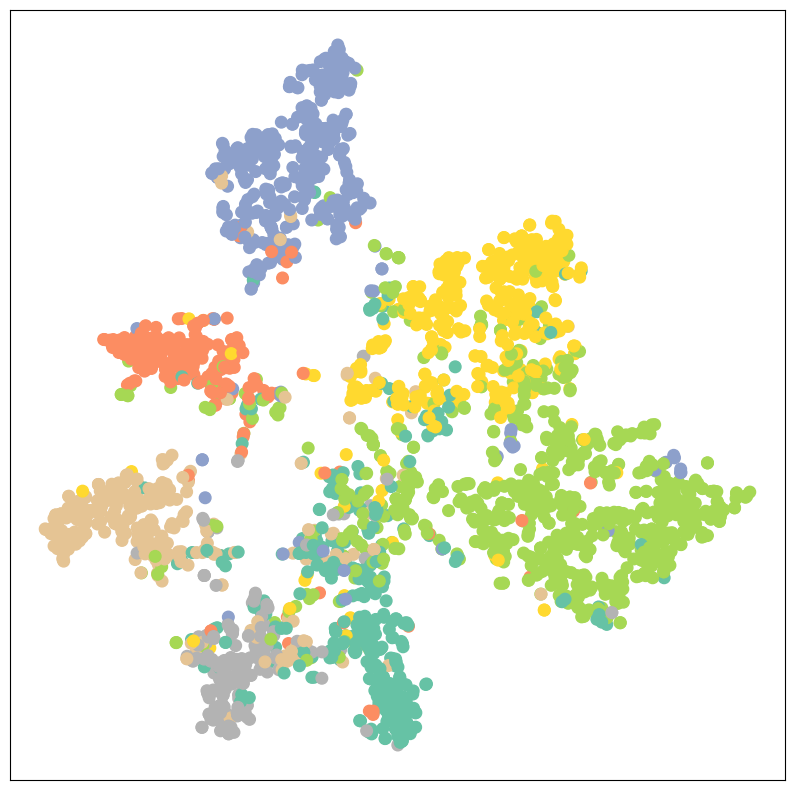

In [72]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Conclusion

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.
In the next section, we will look into how GNNs can be used for the task of graph classification.

[Next: Graph Classification with Graph Neural Networks](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb)

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

3. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

In [73]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads, dropout=.6)  # TODO
        self.conv2 = GATConv(hidden_channels*heads, dataset.num_classes, heads=1, dropout=.6)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 001, Loss: 1.9429, Val: 0.1020, Test: 0.1110
Epoch: 002, Loss: 1.9383, Val: 0.0740, Test: 0.0790
Epoch: 003, Loss: 1.9299, Val: 0.0800, Test: 0.0880
Epoch: 004, Loss: 1.9304, Val: 0.0940, Test: 0.1030
Epoch: 005, Loss: 1.9177, Val: 0.1260, Test: 0.1390
Epoch: 006, Loss: 1.9124, Val: 0.1920, Test: 0.2210
Epoch: 007, Loss: 1.9073, Val: 0.3160, Test: 0.3540
Epoch: 008, Loss: 1.8998, Val: 0.4500, Test: 0.4690
Epoch: 009, Loss: 1.8949, Val: 0.4880, Test: 0.5210
Epoch: 010, Loss: 1.8843, Val: 0.5260, Test: 0.5440
Epoch: 011, Loss: 1.8819, Val: 0.5480, Test: 0.5500
Epoch: 012, Loss: 1.8664, Val: 0.5620, Test: 0.5610
Epoch: 013, Loss: 1.8625, Val: 0.5720, Test: 0.5670
Epoch: 014, Loss: 1.8506, Val: 0.5780, Test: 0.5750
Epoch: 015, Loss: 1.8493, Val: 0.6040, Test: 0.5870
Epoch: 016, Loss: 1.8390, Val: 0.6200, Test: 0.6100
Epoch: 017, Loss: 1.8163, Val: 0.6380, Test: 0.6350
Epoch: 018, Loss: 1.8316, Val: 0.6560

In [74]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8090


In [75]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [76]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch import nn as nn
from torch import optim
import torch

In [77]:
data = make_moons(n_samples=500, noise=0.2)

In [78]:
df = pd.concat([pd.DataFrame(data[0]), pd.DataFrame(data[1], columns=["y"])], axis=1)
df.head()

,0,1,y
0,0.307034,0.874951,0
1,1.268847,-0.152376,1
2,1.073789,-0.008099,0
3,-0.797802,0.658951,0
4,-0.780675,0.456188,0


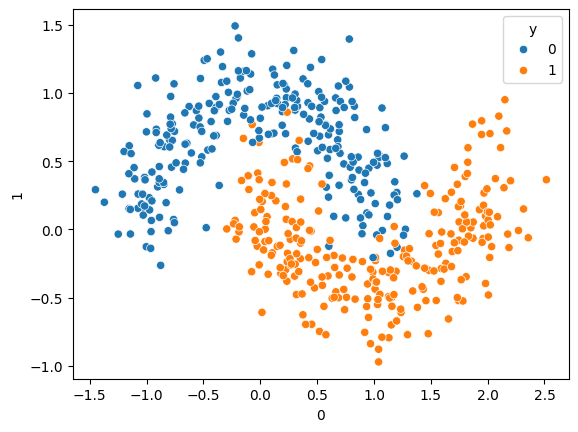

In [79]:
sns.scatterplot(data=df, x=0, y=1, hue="y");

In [80]:
x = np.array(df.drop(["y"], axis=1)).astype(np.float32)
y = np.array(df["y"]).astype(np.float32)

In [7]:
from torch.utils.data import TensorDataset

In [8]:
dataset = TensorDataset(torch.tensor(x).float(), torch.tensor(y).float())

In [9]:
from torch.utils.data import DataLoader, random_split

In [10]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=False)
#test_loader = DataLoader(x_test, batch_size=32, shuffle=False)

In [11]:
train_loader

In [12]:
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [13]:

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [14]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.Linear(10, 5),
    nn.Linear(5, 1)
)

In [15]:
criterion = nn.L1Loss()
metrics = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 1000
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(n_epochs):

    training_loss = 0.0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        feature, target = data

        pred = model(feature)

        loss = criterion(pred, target)


        loss.backward()


        training_loss += loss.item()

        optimizer.step()

        print(f"Loss: {loss.item()}")
    epoch_train_loss.append(training_loss / len(train_loader))

c:\Users\fsimiao\Downloads\Deep-Learning-with-PyTorch\.venv\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
c:\Users\fsimiao\Downloads\Deep-Learning-with-PyTorch\.venv\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loss: 0.658084511756897
Loss: 0.753018856048584
Loss: 0.7637549042701721
Loss: 0.7665578126907349
Loss: 0.8278384208679199
Loss: 0.673862099647522
Loss: 0.6700372695922852
Loss: 0.82259202003479
Loss: 0.693529486656189
Loss: 0.5756236910820007
Loss: 0.7869969606399536
Loss: 0.6697741150856018
Loss: 0.6181818246841431
Loss: 0.5476215481758118
Loss: 0.6316544413566589
Loss: 0.6309826374053955
Loss: 0.540755569934845
Loss: 0.624882161617279
Loss: 0.6364010572433472
Loss: 0.639768123626709
Loss: 0.7033308148384094
Loss: 0.5520368218421936
Loss: 0.5577955842018127
Loss: 0.7052295207977295
Loss: 0.5877905488014221
Loss: 0.4862197935581207
Loss: 0.6806610822677612
Loss: 0.5725293755531311
Loss: 0.5473376512527466
Loss: 0.4638860821723938
Loss: 0.5600470900535583
Loss: 0.5529983639717102
Loss: 0.4798160791397095
Loss: 0.548121452331543
Loss: 0.568839430809021
Loss: 0.5890478491783142
Loss: 0.6329427361488342
Loss: 0.505659282207489
Loss: 0.5204350352287292
Loss: 0.6420423984527588
Loss: 0.5374

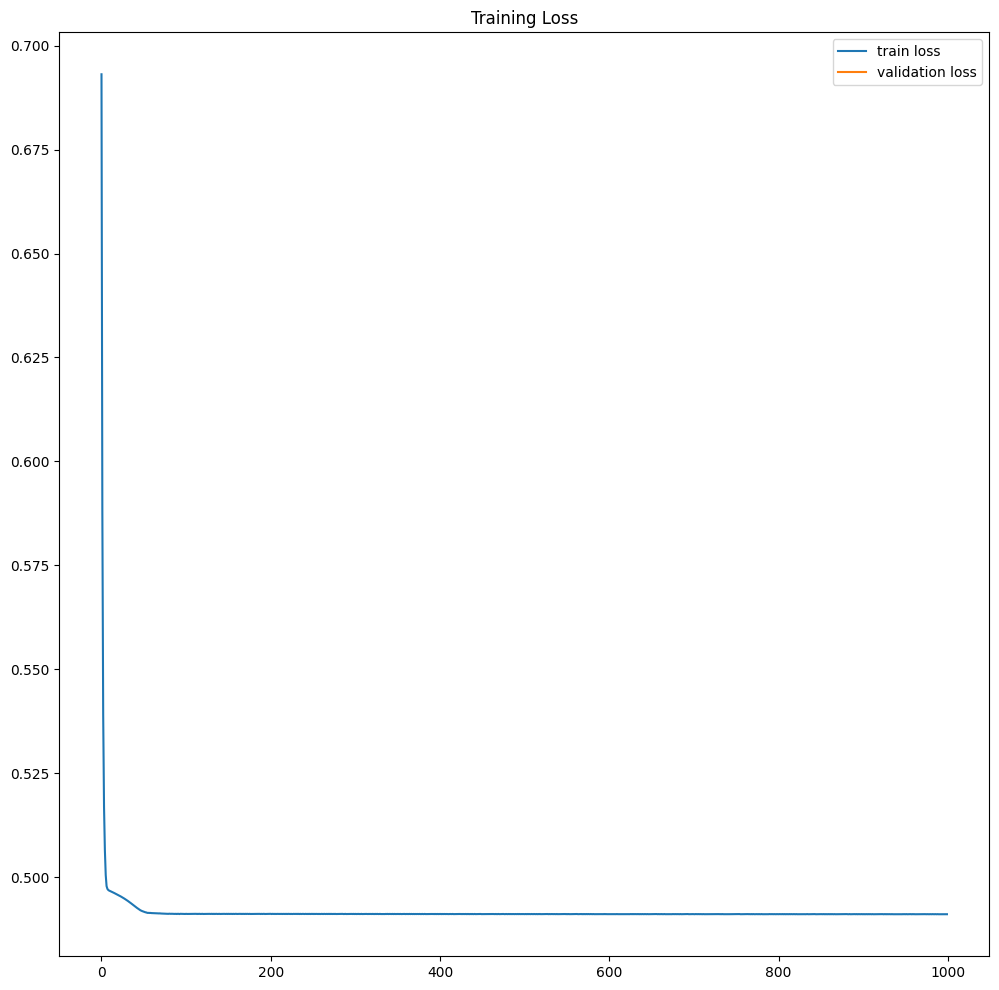

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.title("Training Loss")
plt.legend(["train loss", "validation loss"])
plt.show()

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Keras

In [18]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential

In [19]:
model = Sequential()
model.add(Dense(2))
model.add(Dense(30, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [32]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [33]:
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
13/13 [==============================] - 1s 31ms/step - loss: 0.0355 - accuracy: 0.9575 - val_loss: 0.0304 - val_accuracy: 0.9600
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0347 - accuracy: 0.9575 - val_loss: 0.0285 - val_accuracy: 0.9700
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0348 - accuracy: 0.9600 - val_loss: 0.0278 - val_accuracy: 0.9800
Epoch 4/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0336 - accuracy: 0.9600 - val_loss: 0.0278 - val_accuracy: 0.9700
Epoch 5/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0337 - accuracy: 0.9575 - val_loss: 0.0264 - val_accuracy: 0.9800
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0331 - accuracy: 0.9650 - val_loss: 0.0266 - val_accuracy: 0.9800
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0330 - accuracy: 0.9600 - val_loss: 0.0264 - val_accuracy: 0.9800
Epoch 8/100

<Figure size 1200x1200 with 0 Axes>

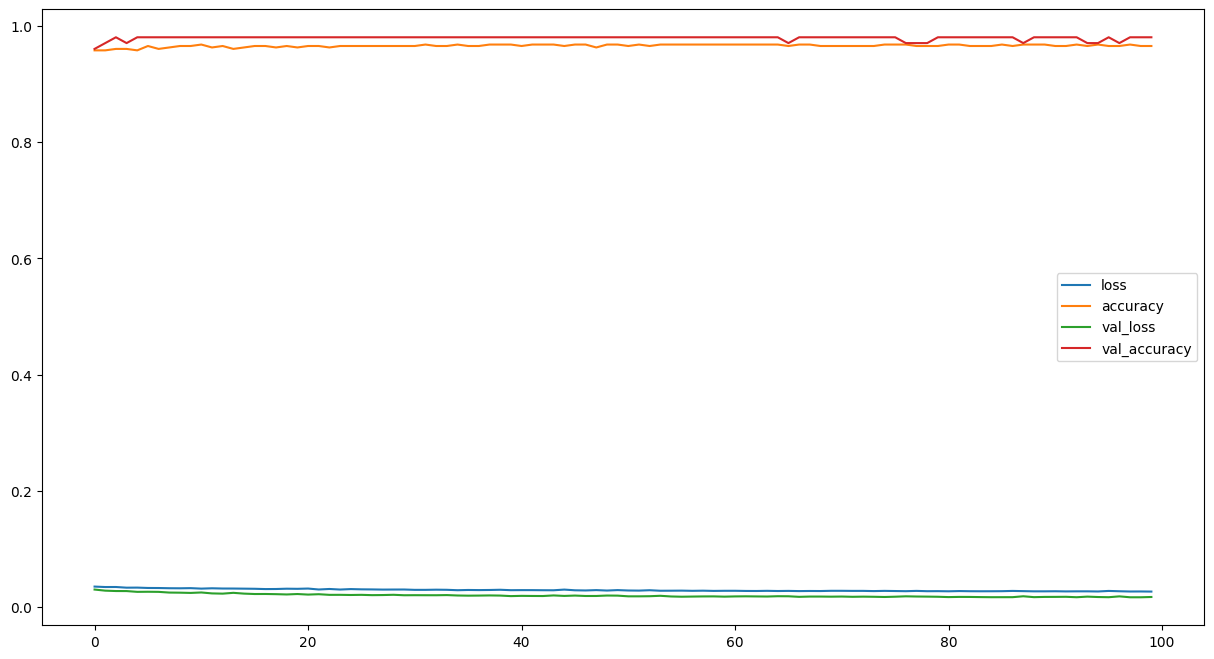

In [34]:
plt.figure(figsize=(12, 12))
pd.DataFrame(history.history).plot(figsize=(15, 8));

In [35]:
from keras.utils import plot_model

In [36]:
model.save_weights("weights.h5")

In [41]:
min(history.history['loss'])

0.026914723217487335

In [40]:
max(epoch_train_loss)

0.6931319124996662

In [50]:
x = torch.tensor(x)
y = torch.tensor(y)

In [54]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(2, 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(2, 2)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [55]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

batch_size = 32

# Split the dataset into train, validate, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create the dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [56]:
import copy
import numpy as np
import torch.nn as nn
import torch.optim as optim
import tqdm

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        # print(epoch)
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [62]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [63]:
ln_model = nn.Sequential(
    LinearRegression(2, 1)
)

In [65]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)


In [58]:
model = Deep()

In [73]:
from catalyst import utils

In [74]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.07)

In [75]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)


In [76]:
X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

In [77]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [78]:
def train(model, epochs):
    losses = []
    max_epochs = epochs
    stop_it = False
    for epoch in range(max_epochs):
        utils.set_global_seed(42 + epoch)
        for it, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outp = model(X_batch)
            loss = loss_function(outp.flatten(), y_batch)
            loss.backward()
            losses.append(loss.detach().flatten()[0])
            optimizer.step()
            probabilities = torch.sigmoid(outp)
            preds = (probabilities>0.5).type(torch.long)
    return model, losses

In [79]:
model, losses = train(model, 20)

In [80]:
def show_loss(losses):
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

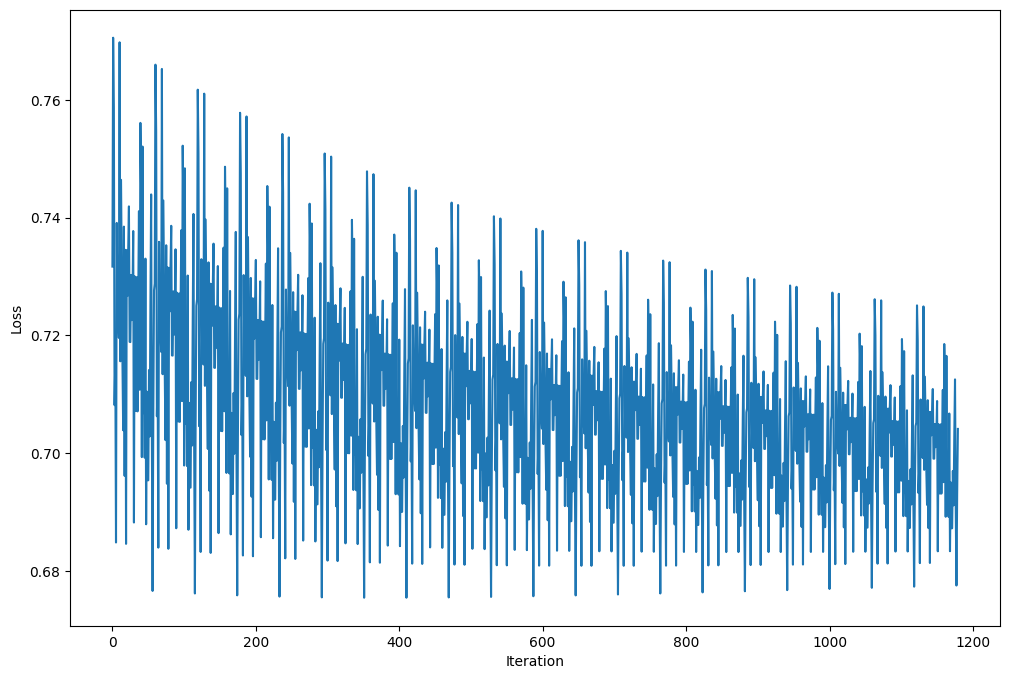

In [81]:
show_loss(losses)


In [82]:
def show_separation(model, save=False, name_to_save=""):
    sns.set(style="white")

    xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    batch = torch.from_numpy(grid).type(torch.float32)
    with torch.no_grad():
        probs = torch.sigmoid(model(batch).reshape(xx.shape))
        probs = probs.numpy().reshape(xx.shape)

    f, ax = plt.subplots(figsize=(16, 10))
    ax.set_title("Decision boundary", fontsize=14)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(xlabel="$X_1$", ylabel="$X_2$")
    if save:
        plt.savefig(name_to_save)
    else:
        plt.show()

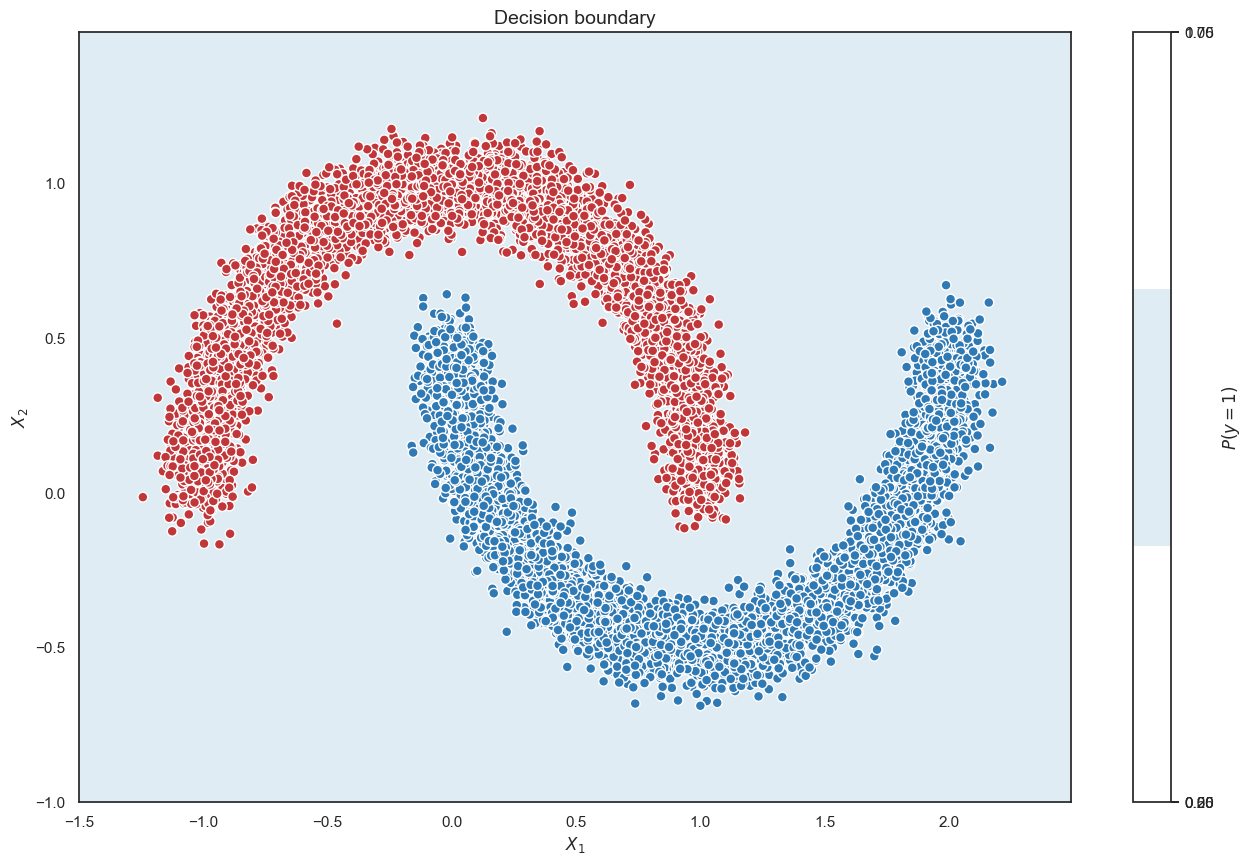

In [83]:
show_separation(model)


In [84]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [85]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, predict(val_dataloader, model))
accuracy

0.4912

In [86]:
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.ReLU(),
    nn.Linear(30, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

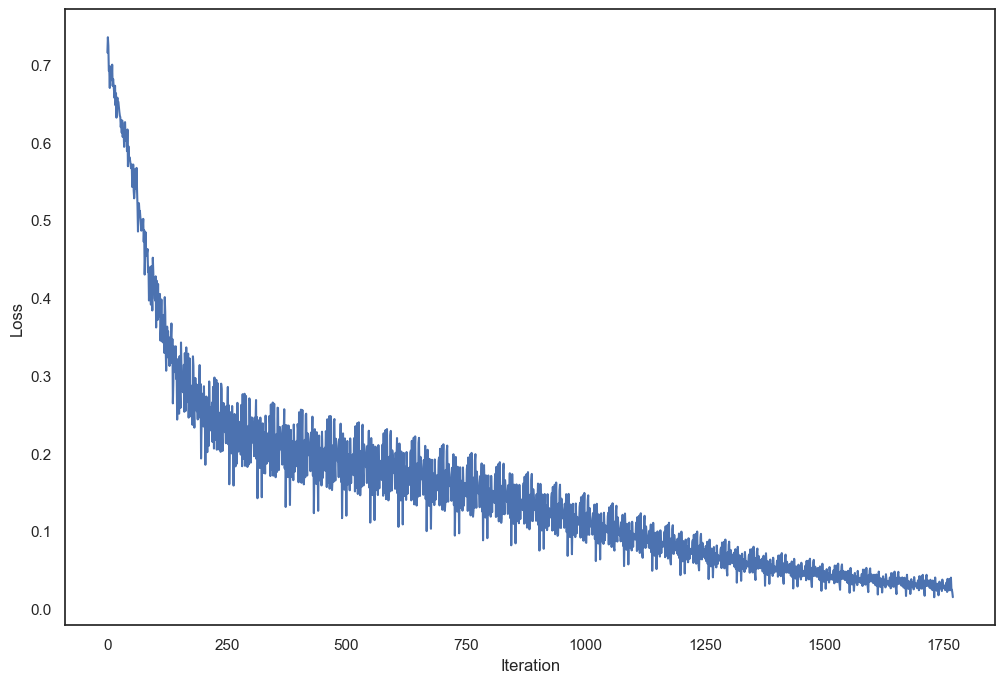

In [87]:
model, losses = train(model, 30)
show_loss(losses)

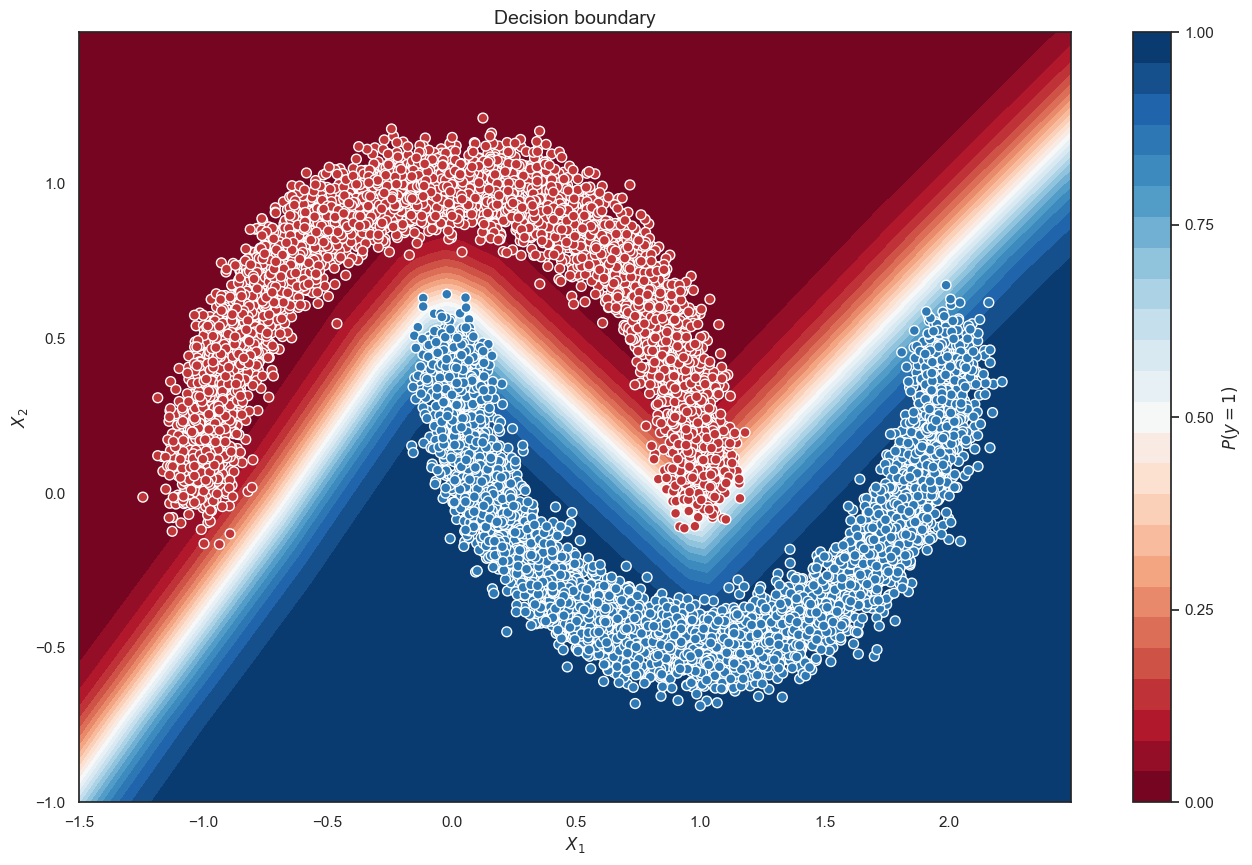

In [88]:
show_separation(model)

In [89]:
accuracy = accuracy_score(y_val, predict(val_dataloader, model))
accuracy

0.9976

In [91]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=10000, random_state=42, noise=0.02)

In [92]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [95]:
x_train

array([[-0.66925948, -0.75406213],
       [ 0.44335534, -0.89290179],
       [-0.66710746,  0.48224315],
       ...,
       [ 0.79583653, -0.1928309 ],
       [ 0.40348416,  0.89480101],
       [-0.69874688,  0.44065226]])

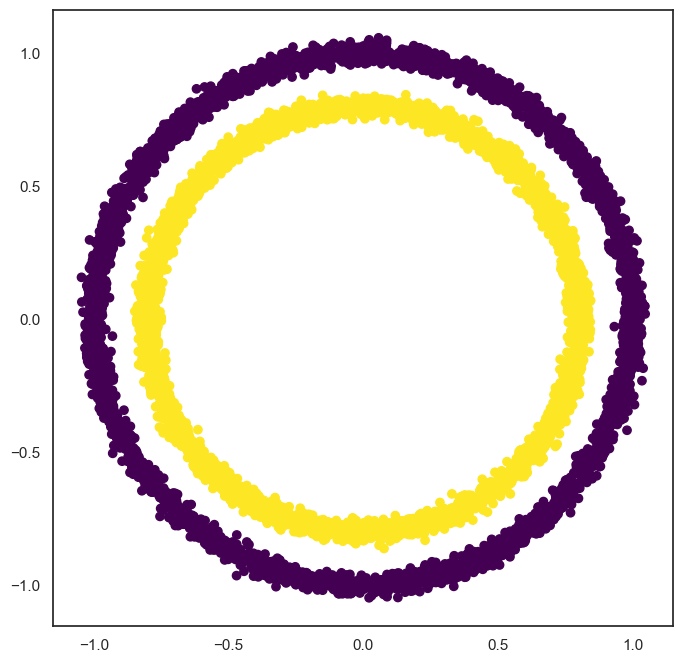

In [104]:
plt.figure(figsize=(8, 8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="viridis");

In [106]:
x_train.shape

(8000, 2)

In [131]:
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.ReLU(),
    nn.Linear(30, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

loss = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02)

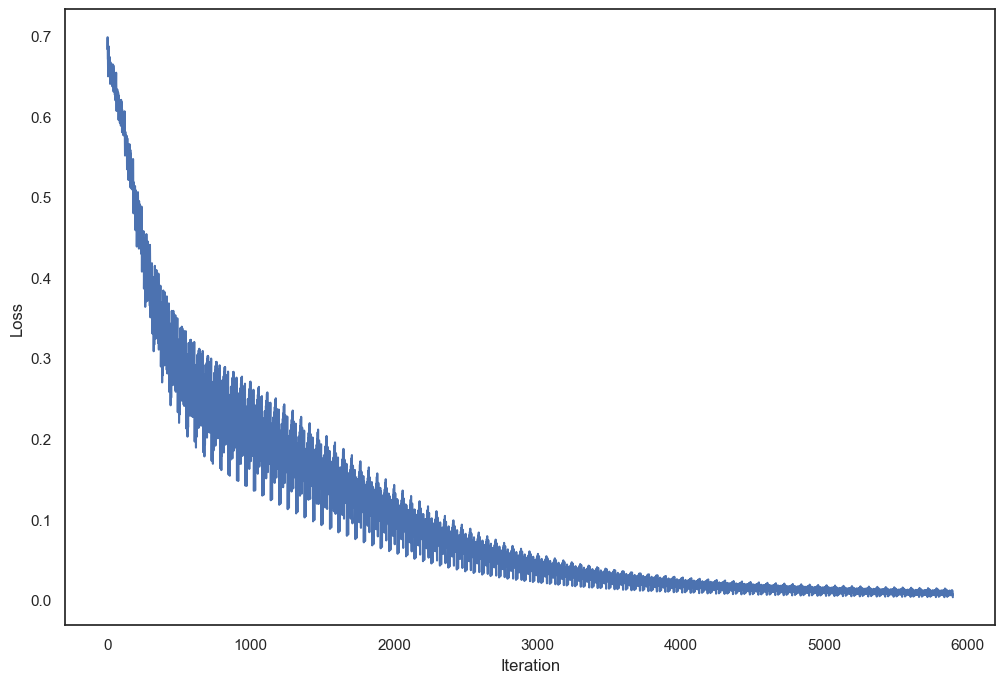

In [132]:
model, loss = train(model, 100)
show_loss(loss)

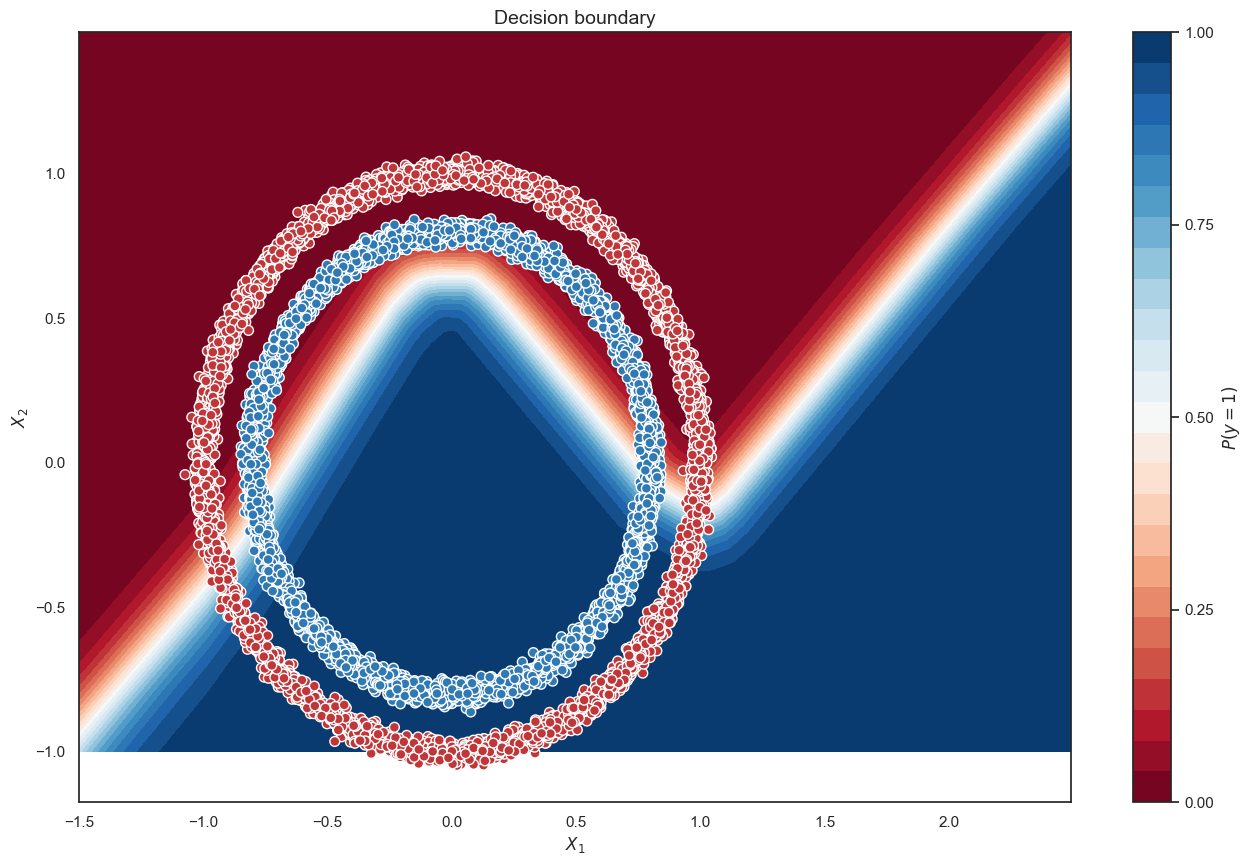

In [135]:
show_separation(model)

In [134]:
accuracy = accuracy_score(y_val, predict(val_dataloader, model))
accuracy

1.0

In [189]:
from sklearn.datasets import make_multilabel_classification

In [193]:
x, y = make_multilabel_classification(n_samples=1000, n_features=5, n_classes=5)

In [194]:
y

array([[1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1]])

,0,1,2,3,4
0,1,0,0,0,1
1,0,0,0,0,0
2,0,1,0,0,1
3,0,0,0,0,0
4,0,1,0,1,0
...,...,...,...,...,...
995,0,1,0,0,1
996,0,0,0,0,1
997,0,1,0,0,1
998,1,1,0,1,1
